In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


El grupo de pozos pertenece a un mismo campo, y los datos de producción fueron suministrados por un consultor de yacimientos. Los procedimientos que queremos generar aquí se espera que puedan ser aplicados a cualquier pozo de este campo u otro campo desde que se cuente con la suficiente información ya que las curvas generadas son especificas para cada pozo, y lo que se quiere lograr es comparar estos métodos de regresión con la ecuación de ARPS que suele ser mas general.

In [ ]:
xlsx_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQyTtJmcEZCwTnvjw4NcxIjcgqv9mHO3OdKo8D6ORP_nkOQazFMZhczKkfZTXX3IUfAx0a9dGRyMPDM/pub?output=xlsx'
df = pd.read_excel(xlsx_path)
wells = df['Well'].unique()
wells

array(['W4', 'W5', 'W0', 'W2', 'W3', 'W1'], dtype=object)

In [ ]:
df.dtypes

Well                        object
Date                datetime64[ns]
Oil rate (stb/d)           float64
dtype: object

Se van a crear las funciones que se usarán después:


*   En la función RegularPlot se creará una grafica de todos los datos de producción de los pozos de los cuales seleccionaremos un grupo de ellos para trabajar.
*   En la función NormalisedData se creará un diccionario con los datos normalizados utilizando como etiqueta los nombres de los pozos, y en ellos colocaremos la tasa de producción de aceite y el dato normalizado de fecha. Para lograr normalizar la fecha se busca la fecha más antigua entre los datos y se calcula cuantos días pasaron con respecto a esta fecha para cada dato de producción.
*   En la función NormalisedPlot se creará una grafica como la primera pero usando la fecha ya normalizada.










In [ ]:
def RegularPlot(df, wells, units):
    fig, ax = plt.subplots(figsize=(15,8))
    plt.xlabel('Date')
    plt.ylabel('Rate '+ units)
    for well in wells:
        df_filtered = df[df['Well']==well]
        rate = df_filtered['Oil rate (stb/d)']
        date = df_filtered['Date']
        ax.plot(date, rate, 'o', label=well)
    ax.legend(shadow=True, fancybox=True)
    return plt

def NormalisedData(df, wells):
    norm_data = {}
    for well in wells:
        df_filtered = df[df['Well']==well]
        start_date = min(df_filtered['Date'])
        rate = df_filtered['Oil rate (stb/d)']
        time = df_filtered['Date'] - start_date
        time = time.dt.days
        norm_data[well] = {
            'rate': rate,
            'time': time
        }
    return norm_data

def NormalisedPlot(df, wells):
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.xlabel('Days')
    plt.ylabel('Rate')
    for well in wells:
        df_filtered = df[df['Well']==well]
        start_date = min(df_filtered['Date'])
        rate = df_filtered['Oil rate (stb/d)']
        time = df_filtered['Date'] - start_date
        time = time.dt.days
        ax.plot(time, rate, 'o', label=well)
    ax.legend(shadow=True, fancybox=True)
    return plt

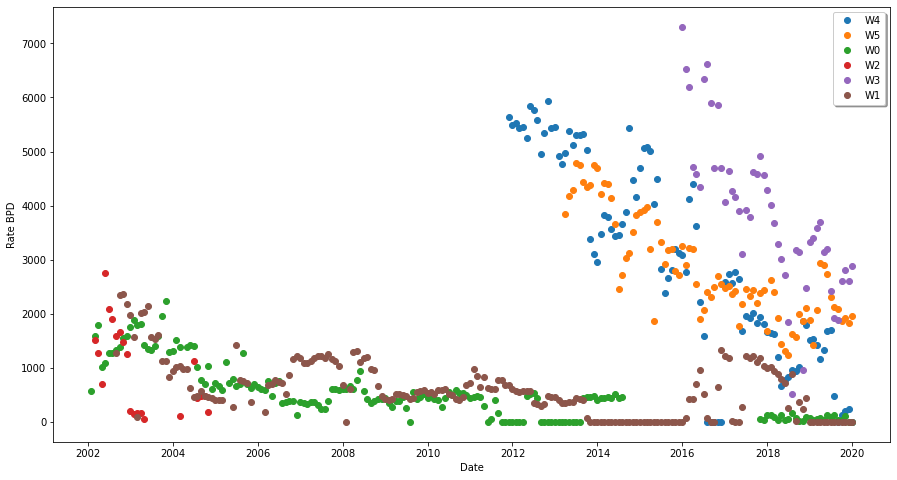

In [ ]:
plot_data = RegularPlot (df, wells, 'BPD')

Seleccionamos un pozo de interés para poner a prueba los distintos metodos de Machine Learning y el método de ARPS. Luego con la función que creamos anteriormente normalizamos los datos y graficamos los datos normalizados con la otra función creada. Nota: Se mostrarán los datos de un pozo para saber como quedaron los datos ya normalizados
A este grupo de pozos se le hará otro preprocesado el cual consiste en eliminar los ceros y reemplazarlos por el promedio de los datos de producción de ese pozo.
Nota: Se seleccionan los pozos 3, 4 y 5 porque son los que actualmente están produciendo, y las conclusiones que saquemos de ellos pueden ser significantes o ayudarnos a tomar decisiones.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


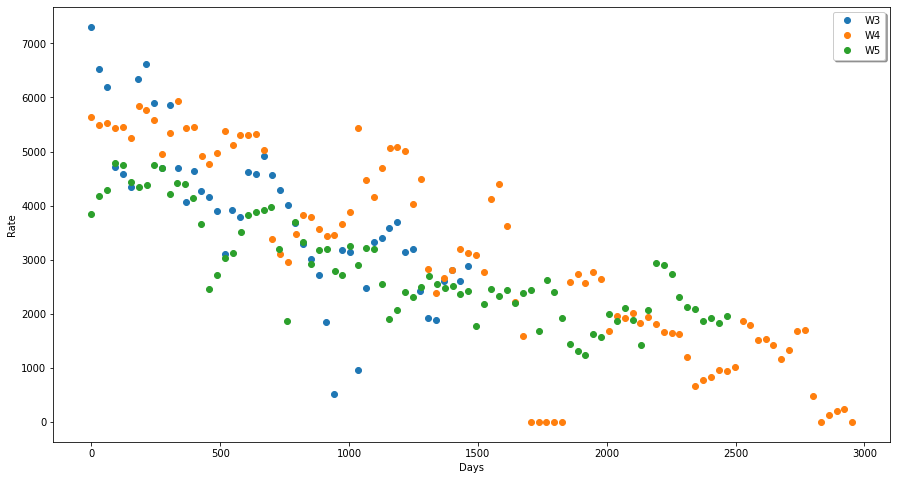

In [ ]:
selected_wells = ['W3','W4','W5']
normalised_data = NormalisedData(df, selected_wells)
normalised_plot = NormalisedPlot(df, selected_wells)
avg_W3 = normalised_data['W3']['rate'].astype('float').mean(axis=0)
normalised_data['W3']['rate'].replace(0, avg_W3, inplace=True)
avg_W4 = normalised_data['W4']['rate'].astype('float').mean(axis=0)
normalised_data['W4']['rate'].replace(0, avg_W4, inplace=True)
avg_W5 = normalised_data['W5']['rate'].astype('float').mean(axis=0)
normalised_data['W5']['rate'].replace(0, avg_W5, inplace=True)
score={}
datat=0.8

Regresión polinomial por pozo

Grado 1 (Lineal)

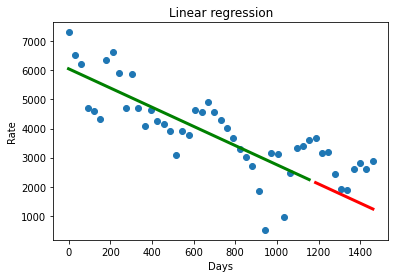

Precisión del modelo lineal W3 : 0.6232314167353163


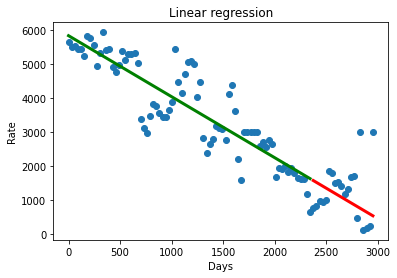

Precisión del modelo lineal W4 : 0.7842804574964212


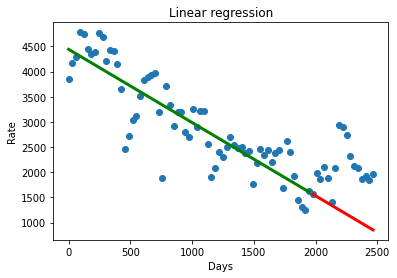

Precisión del modelo lineal W5 : 0.7712511013905001

-3.596070065672869
-0.3316886907716652
-5.15555945744676


In [ ]:
for well in selected_wells:
  X_l = normalised_data[well]['time'].values.reshape(-1, 1)  #necesitamos un array de 2D para SkLearn
  y_l = normalised_data[well]['rate'].values.reshape(-1, 1)
  #Separo los datos en entrenamiento y prueba
  X_train_l=X_l[:int(len(X_l)*datat)]
  X_test_l=X_l[int(len(X_l)*datat):]
  y_train_l=y_l[:int(len(y_l)*datat)]
  y_test_l=y_l[int(len(y_l)*datat):]
  #Importar la librería con características polinomiales
  from sklearn.preprocessing import PolynomialFeatures
  #Se define el grado del polinomio
  poli_reg = PolynomialFeatures(degree=1)
  #Se transforma las características existentes en características de mayor grado
  X_train_lin = poli_reg.fit_transform(X_train_l)
  X_test_lin = poli_reg.fit_transform(X_test_l)
  #Defino el algoritmo a utilizar
  pr = linear_model.LinearRegression()
  #Entreno el modelo
  pr.fit(X_train_lin, y_train_l)
  #Realizo una predicción
  Y_pred_l = pr.predict(X_test_lin)
  Y_pred1_l = pr.predict(X_train_lin)
  plt.scatter(X_l, y_l)
  plt.plot(X_test_l, Y_pred_l, color='red', linewidth=3)
  plt.plot(X_train_l, Y_pred1_l, color='green', linewidth=3)
  plt.xlabel('Days')
  plt.ylabel('Rate')
  plt.title('Linear regression')
  plt.show()
  print('Precisión del modelo lineal',well,':',pr.score(X_train_lin, y_train_l))
  score[well]={
    'Regresión lineal':r2_score(y_test_l,Y_pred_l)
}

print()
LINW3=score['W3']['Regresión lineal']
print(LINW3)
LINW4=score['W4']['Regresión lineal']
print(LINW4)
LINW5=score['W5']['Regresión lineal']
print(LINW5)

Grado 2 (Cuadratica)

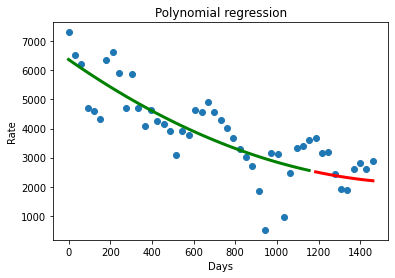

Precisión del modelo polinomial W3 : 0.6347491036254054


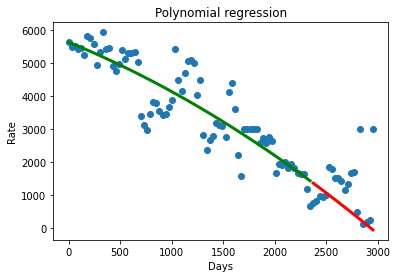

Precisión del modelo polinomial W4 : 0.7887097183718863


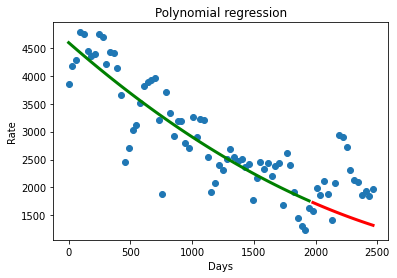

Precisión del modelo polinomial W5 : 0.7770219180817906

-0.3587820000688109
-1.0427658561354334
-2.196702300969066


In [ ]:
for well in selected_wells:
  X_p = normalised_data[well]['time'].values.reshape(-1, 1)  #necesitamos un array de 2D para SkLearn
  y_p = normalised_data[well]['rate'].values.reshape(-1, 1)
  #Separo los datos en entrenamiento y prueba
  X_train_p=X_p[:int(len(X_p)*datat)]
  X_test_p=X_p[int(len(X_p)*datat):]
  y_train_p=y_p[:int(len(y_p)*datat)]
  y_test_p=y_p[int(len(y_p)*datat):]
  #Importar la librería con características polinomiales
  from sklearn.preprocessing import PolynomialFeatures
  #Se define el grado del polinomio
  poli_reg = PolynomialFeatures(degree=2)
  #Se transforma las características existentes en características de mayor grado
  X_train_poli = poli_reg.fit_transform(X_train_p)
  X_test_poli = poli_reg.fit_transform(X_test_p)
  #Defino el algoritmo a utilizar
  pr = linear_model.LinearRegression()
  #Entreno el modelo
  pr.fit(X_train_poli, y_train_p)
  #Realizo una predicción
  Y_pred_pr = pr.predict(X_test_poli)
  Y_pred1_pr = pr.predict(X_train_poli)
  plt.scatter(X_p, y_p)
  plt.plot(X_test_p, Y_pred_pr, color='red', linewidth=3)
  plt.plot(X_train_p, Y_pred1_pr, color='green', linewidth=3)
  plt.xlabel('Days')
  plt.ylabel('Rate')
  plt.title('Polynomial regression')
  plt.show()
  print('Precisión del modelo polinomial',well,':',pr.score(X_train_poli, y_train_p))
  score[well]={
    'Regresión cuadratica':r2_score(y_test_p,Y_pred_pr)
}

print()
POLW3=score['W3']['Regresión cuadratica']
print(POLW3)
POLW4=score['W4']['Regresión cuadratica']
print(POLW4)
POLW5=score['W5']['Regresión cuadratica']
print(POLW5)

Soporte vectores de regresión

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


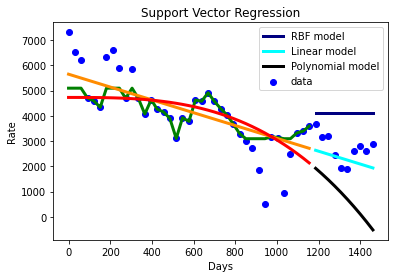

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión del modelo SVR-RBF W3 : 0.6680381728837474
Precisión del modelo SVR-Linear W3 : 0.5898492504147612
Precisión del modelo SVR-Polinomial W3 : 0.4329286576692579


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


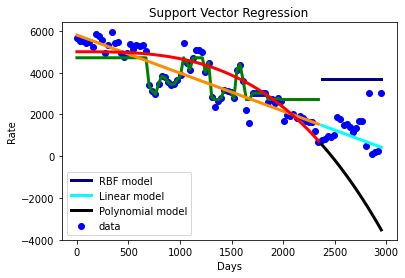

Precisión del modelo SVR-RBF W4 : 0.8072380343470189
Precisión del modelo SVR-Linear W4 : 0.7818634517721413
Precisión del modelo SVR-Polinomial W4 : 0.6891451106776938


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


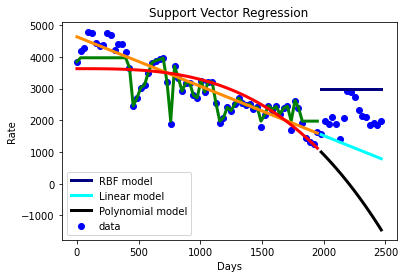

Precisión del modelo SVR-RBF W5 : 0.9136660037086689
Precisión del modelo SVR-Linear W5 : 0.7575477823424747
Precisión del modelo SVR-Polinomial W5 : 0.6001940453159911

-6.654711341347713
-0.49895421286165065
-14.36607170377628

-9.797397726558964
-0.4330500398157131
-14.202231102778025

-4.666220894409669
-5.640907229858355
-33.953581701067


In [ ]:
for well in selected_wells:
  X_svr = normalised_data[well]['time'].values.reshape(-1, 1)
  Y_svr = normalised_data[well]['rate'].values.reshape(-1, 1)
  X_train1=X_svr[:int(len(X_svr)*datat)]
  X_test1=X_svr[int(len(X_svr)*datat):]
  Y_train1=Y_svr[:int(len(Y_svr)*datat)]
  Y_test1=Y_svr[int(len(Y_svr)*datat):]
  X_train2=X_svr[:int(len(X_svr)*datat)]
  X_test2=X_svr[int(len(X_svr)*datat):]
  Y_train2=Y_svr[:int(len(Y_svr)*datat)]
  Y_test2=Y_svr[int(len(Y_svr)*datat):]
  X_train3=X_svr[:int(len(X_svr)*datat)]
  X_test3=X_svr[int(len(X_svr)*datat):]
  Y_train3=Y_svr[:int(len(Y_svr)*datat)]
  Y_test3=Y_svr[int(len(Y_svr)*datat):]
  from sklearn.svm import SVR
  #IMPORTANTE: En este caso, ambos predictores (X1, X2) tienen la misma escala por lo que no es necesario estandarizarlos. En aquellas situaciones en las que las escalas son distintas, sí hay que estandarizarlos, de lo contrario, los predictores de mayor magnitud eclipsarán a los de menor magnitud.
  #Existen varios tipos de kernel (linear, poly, rbf, sigmoid, precomputed). El valor de C y epsilon se dejarán como los que por defecto se usan más.
  svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
  svr_lin = SVR(kernel='linear', C=1e3)
  svr_poly = SVR(kernel='poly', C=1e3, degree=3)

  svr_rbf.fit(X_train1, Y_train1)
  svr_lin.fit(X_train2, Y_train2)
  svr_poly.fit(X_train3, Y_train3)

  Y_pred1 = svr_rbf.predict(X_test1)
  Y_pred11 = svr_rbf.predict(X_train1)
  Y_pred2 = svr_lin.predict(X_test2)
  Y_pred21 = svr_lin.predict(X_train2)
  Y_pred3 = svr_poly.predict(X_test3)
  Y_pred31 = svr_poly.predict(X_train3)

  plt.scatter(X_svr, Y_svr, color='blue', label='data')
  plt.plot(X_test1, Y_pred1, color='navy', linewidth=3, label='RBF model')
  plt.plot(X_test2, Y_pred2, color='cyan', linewidth=3, label='Linear model')
  plt.plot(X_test3, Y_pred3, color='black', linewidth=3, label='Polynomial model')
  plt.plot(X_train1, Y_pred11, color='green', linewidth=3)
  plt.plot(X_train2, Y_pred21, color='darkorange', linewidth=3)
  plt.plot(X_train3, Y_pred31, color='red', linewidth=3)
  plt.xlabel('Days')
  plt.ylabel('Rate')
  plt.title('Support Vector Regression')
  plt.legend()
  plt.show()

  print('Precisión del modelo SVR-RBF',well,':', svr_rbf.score(X_train1, Y_train1))
  print('Precisión del modelo SVR-Linear',well,':', svr_lin.score(X_train2, Y_train2))
  print('Precisión del modelo SVR-Polinomial',well,':', svr_poly.score(X_train3, Y_train3))

  score[well]={
    'SVR-RBF':r2_score(Y_test1,Y_pred1),
    'SVR-Linear':r2_score(Y_test2,Y_pred2),
    'SVR-Polinomial':r2_score(Y_test3,Y_pred3)
  }

print()
SVRRBFW3=score['W3']['SVR-RBF']
print(SVRRBFW3)
SVRLINW3=score['W3']['SVR-Linear']
print(SVRLINW3)
SVRPOLW3=score['W3']['SVR-Polinomial']
print(SVRPOLW3)
print()
SVRRBFW4=score['W4']['SVR-RBF']
print(SVRRBFW4)
SVRLINW4=score['W4']['SVR-Linear']
print(SVRLINW4)
SVRPOLW4=score['W4']['SVR-Polinomial']
print(SVRPOLW4)
print()
SVRRBFW5=score['W5']['SVR-RBF']
print(SVRRBFW5)
SVRLINW5=score['W5']['SVR-Linear']
print(SVRLINW5)
SVRPOLW5=score['W5']['SVR-Polinomial']
print(SVRPOLW5)



Arboles de decisión regresión

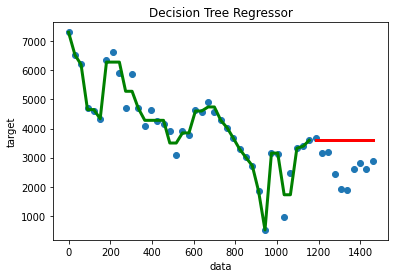

Precisión del modelo ADR W3 : 0.9662191621877888


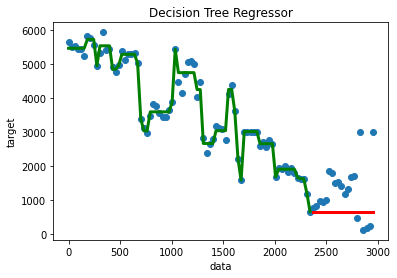

Precisión del modelo ADR W4 : 0.9885956418852152


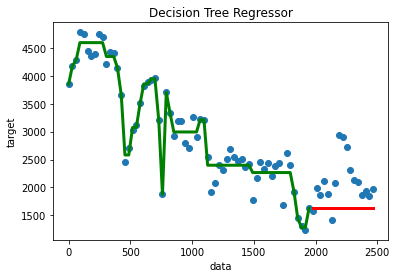

Precisión del modelo ADR W5 : 0.9667708972305431

-2.6932339862364376
-0.6278458318043634
-1.297382033453835


In [ ]:
for well in selected_wells:
  X_adr = normalised_data[well]['time'].values.reshape(-1, 1)
  Y_adr = normalised_data[well]['rate'].values.reshape(-1, 1)
  X_train=X_adr[:int(len(X_adr)*datat)]
  X_test=X_adr[int(len(X_adr)*datat):]
  y_train=Y_adr[:int(len(Y_adr)*datat)]
  y_test=Y_adr[int(len(Y_adr)*datat):]
  from sklearn.tree import DecisionTreeRegressor
  #Defino el algoritmo a utilizar
  adr = DecisionTreeRegressor(max_depth = 5)
  #Entreno el modelo
  adr.fit(X_train, y_train)
  #Realizo una predicción
  Y_pred1 = adr.predict(X_train)
  Y_pred = adr.predict(X_test)
  #Graficamos los datos de prueba junto con la predicción
  plt.scatter(X_adr, Y_adr)
  plt.plot(X_test, Y_pred, color='red', linewidth=3)
  plt.plot(X_train, Y_pred1, color='green', linewidth=3)
  plt.xlabel('data')
  plt.ylabel('target')
  plt.title('Decision Tree Regressor')
  plt.show()

  print('Precisión del modelo ADR',well,':', adr.score(X_train, y_train)) 
  
  score[well]={
    'ADR':r2_score(y_test,Y_pred),
  }

print()
ADRW3=score['W3']['ADR']
print(ADRW3)
ADRW4=score['W4']['ADR']
print(ADRW4)
ADRW5=score['W5']['ADR']
print(ADRW5)

Ecuación de Arps

En la función de ARPS se definirá la curva exponencial de declinación de petroleo que luego graficaremos para comparar con los diferentes métodos de regresión. Se dete tener en cuenta las 3 condiciones del factor b que termina si es exponencial (b=0), armonica (b=1) ó hiperbolica (0<b<1).

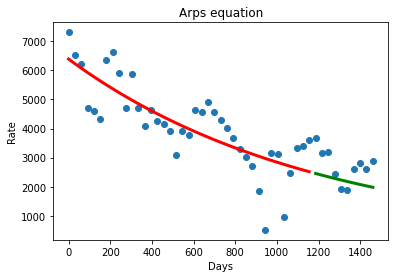

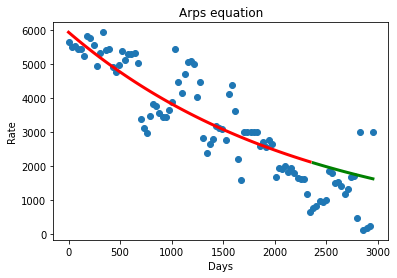

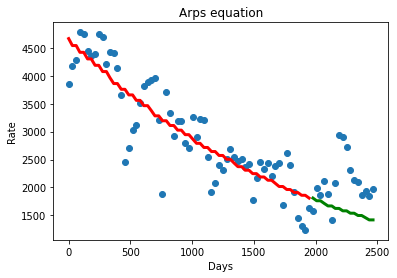


-0.7501736583864085
-0.621406795260296
-1.6618205016485406


In [ ]:
def arps(t, b_factor, initial_rate, decline):   #Definimos la función de ARPS
    if b_factor == 0:                           #Declinación exponencial
        values = initial_rate * np.exp(-decline * t)   
    elif b_factor == 1:                         #Declinación armonica
        values = initial_rate / (1 + decline*t)        
    else:                                       #Declinación hiperbolica
        values = initial_rate / ((1 + b_factor * decline * t) ** (1 / b_factor))      
    return values

fitdict={}
for well in selected_wells:
    X_p = normalised_data[well]['time']        
    Y_p = normalised_data[well]['rate']
    X_arps=X_p[:int(len(X_p)*datat)]           #80% de los datos como entrenamiento
    Y_arps=Y_p[:int(len(Y_p)*datat)]
    Maxrate=max(Y_arps)                        #Se calcula la tasa de producción de aceite maxima
    popt, pcov = curve_fit(arps, X_arps, Y_arps, bounds=([0, 0, 0],[1, Maxrate, 0.1]))    #Se realiza un ajuste a la ecuación de Arps usando esos limites y los datos de entrenamiento
    fitdict[well]={
      'initial rate': popt[1],
      'beta': popt[0],
      'decline rate': popt[2] 
    }

time_predict=[]
rate_predict=[]
arps_predict={}
for well in selected_wells:
    X_p = normalised_data[well]['time']
    time_train=X_p[:int(len(X_p)*datat)]   
    time_predict=X_p[int(len(X_p)*datat):]    #20% de los datos como prueba
    Y_p = normalised_data[well]['rate']
    rate_test=Y_p[int(len(Y_p)*datat):]
    for time in time_predict:
      rate_predict=arps(time_predict, fitdict[well]['beta'], fitdict[well]['initial rate'], fitdict[well]['decline rate'])
      rate_train=arps(time_train, fitdict[well]['beta'], fitdict[well]['initial rate'], fitdict[well]['decline rate'])
    arps_predict[well]={
        'time':time_predict,
        'rate':rate_predict
    }
    plt.scatter(X_p, Y_p)
    plt.plot(time_predict, rate_predict, color='green', linewidth=3)
    plt.plot(time_train, rate_train, color='red', linewidth=3)
    plt.xlabel('Days')
    plt.ylabel('Rate')
    plt.title('Arps equation')
    plt.show()
    score[well]={
    'Arps':r2_score(rate_test,rate_predict)
    }

print()
ArpsW3= score['W3']['Arps'] 
print(ArpsW3) 
ArpsW4= score['W4']['Arps']
print(ArpsW4) 
ArpsW5= score['W5']['Arps']
print(ArpsW5) 

Precisión de los modelos

R² = 1 - RSS / TSS, where RSS is the residual sum of squares ∑(y - f(x))² and TSS is the total sum of squares ∑(y - mean(y))². 

In [ ]:
print('Las precisiones de los modelos para W3 son')
print('Regresión lineal es',LINW3)
print('Regresión polinomial es',POLW3)
print('Regresión SVR-RBF es',SVRRBFW3)
print('Regresión SVR-Lineal es',SVRLINW3)
print('Regresión SVR-Polinomial es',SVRPOLW3)
print('Arbol de regresión es',ADRW3)
print('Ecuación de Arps es',ArpsW3)
print()
print('Las precisiones de los modelos para W4 son')
print('Regresión lineal es',LINW4)
print('Regresión polinomial es',POLW4)
print('Regresión SVR-RBF es',SVRRBFW4)
print('Regresión SVR-Lineal es',SVRLINW4)
print('Regresión SVR-Polinomial es',SVRPOLW4)
print('Arbol de regresión es',ADRW4)
print('Ecuación de Arps es',ArpsW4)
print()
print('Las precisiones de los modelos para W5 son')
print('Regresión lineal es',LINW5)
print('Regresión polinomial es',POLW5)
print('Regresión SVR-RBF es',SVRRBFW5)
print('Regresión SVR-Lineal es',SVRLINW5)
print('Regresión SVR-Polinomial es',SVRPOLW5)
print('Arbol de regresión es',ADRW5)
print('Ecuación de Arps es',ArpsW5)

Las precisiones de los modelos para W3 son
Regresión lineal es -3.596070065672869
Regresión polinomial es -0.3587820000688109
Regresión SVR-RBF es -6.654711341347713
Regresión SVR-Lineal es -0.49895421286165065
Regresión SVR-Polinomial es -14.36607170377628
Arbol de regresión es -2.6932339862364376
Ecuación de Arps es -0.7501736583864085

Las precisiones de los modelos para W4 son
Regresión lineal es -0.3316886907716652
Regresión polinomial es -1.0427658561354334
Regresión SVR-RBF es -9.797397726558964
Regresión SVR-Lineal es -0.4330500398157131
Regresión SVR-Polinomial es -14.202231102778025
Arbol de regresión es -0.6278458318043634
Ecuación de Arps es -0.621406795260296

Las precisiones de los modelos para W5 son
Regresión lineal es -5.15555945744676
Regresión polinomial es -2.196702300969066
Regresión SVR-RBF es -4.666220894409669
Regresión SVR-Lineal es -5.640907229858355
Regresión SVR-Polinomial es -33.953581701067
Arbol de regresión es -1.297382033453835
Ecuación de Arps es -1.66

**Conclusiones**

*   Para este caso de estudio, se tuvo solo en consideración el caudal en función del tiempo como variables y que no se tomaron en cuenta otras condiciones del pozo para hacer el análisis. Estas consideraciones son útiles para determinar una curva base, ya que las predicciones se obtienen sin tener en cuenta una intervención externa para cambiar su producción. 
*   La regresión polinomial es adecuada para este grupo de pozos ya que se trabaja con una sola variable independiente, pero se debe tener cuidado al aumentar el grado del polinomio para no incurrir en un sobre ajuste. Como se trabaja con una sola variable independiente se elimina el riesgo de las variables independientes se relacionan entre ellas generando multicolinealidad.
*   Al generar un hiperplano que maximiza el margen, por medio de soportes de vectores de regresión, el kernel lineal obtiene una línea recta que tiene el mejor ajuste por este método.
*   Al comparar los métodos de machine learning con el  modelo de ARPS se obtuvo una mejor precisión con el método de ARPS para este trabajo, sin embargo, el método de regresión polinomial y árbol de decisión obtiene buenos valores de predicción. 












